# 梅雨前線

2018年の西日本豪雨に関する力学解析{cite}`Enomoto:2019`を行います。
これまでは取得した変数をそのまま描画していましたが，MetPyの助けを借りて別の物理量を計算してみましょう。
MetPyには気象のデータ解析に関する様々な機能がありますが，ここでは単位`metpy.units.units`と計算`metpy.calc`を利用します。

In [86]:
import numpy as np
import xarray as xr
from metpy.units import units
import metpy.calc as mpcalc
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

## データの取得

ここでは，NCEP日別現業解析を利用します。
`xarray.Dataset`を作り，気圧面と領域を`.sel()`メソッドで切り出します。
年別・変数別のファイルになっているので，一旦リストにして`xarray.merge()`で`xarray.Dataset`にまとめます。

In [105]:
dods = "https://psl.noaa.gov/thredds/dodsC/Datasets/ncep"
yyyy = 2018
yyyymmdd = f"{yyyy}-07-05"
lev = 850
lat = np.linspace(20, 50, 13)
lon = np.linspace(115, 150, 15)
vars = []
for var in ["air", "rhum", "hgt", "uwnd", "vwnd"]:
    ds = xr.open_dataset(f"{dods}/{var}.{yyyy}.nc")
    vars.append(ds[var].sel(time=yyyymmdd, level=lev, lat=lat, lon=lon))
ds = xr.merge(vars)

c:\users\subhi\appdata\local\programs\python\python39\lib\site-packages\xarray\conventions.py:512: SerializationWarning: variable 'air' has multiple fill values {-99, 32767}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
c:\users\subhi\appdata\local\programs\python\python39\lib\site-packages\xarray\conventions.py:512: SerializationWarning: variable 'rhum' has multiple fill values {-99, 32767}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
c:\users\subhi\appdata\local\programs\python\python39\lib\site-packages\xarray\conventions.py:512: SerializationWarning: variable 'hgt' has multiple fill values {-999.0, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
c:\users\subhi\appdata\local\programs\python\python39\lib\site-packages\xarray\conventions.py:512: SerializationWarning: variable 'uwnd' has multiple fill values {-99, 32767}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
c:\users\subhi\appdata\local\pro

In [106]:
ds

<xarray.Dataset>
Dimensions:  (lon: 15, lat: 13)
Coordinates:
  * lon      (lon) float32 115.0 117.5 120.0 122.5 ... 142.5 145.0 147.5 150.0
  * lat      (lat) float32 20.0 22.5 25.0 27.5 30.0 ... 40.0 42.5 45.0 47.5 50.0
    level    float32 850.0
    time     datetime64[ns] 2018-07-05
Data variables:
    air      (lat, lon) float32 ...
    rhum     (lat, lon) float32 ...
    hgt      (lat, lon) float32 ...
    uwnd     (lat, lon) float32 ...
    vwnd     (lat, lon) float32 ...
Attributes:
    long_name:             Air temperature
    unpacked_valid_range:  [150. 350.]
    actual_range:          [180.72499 321.2337 ]
    units:                 degK
    var_desc:              Air temperature
    precision:             2
    dataset:               NCEP
    level_desc:            Multiple levels
    statistic:             Mean
    parent_stat:           Individual Obs
    valid_range:           [-32765 -12765]

## 相当温位

理想気体の状態方程式は

$$
p\alpha = RT
$$ (idealgas)

と表すことができます。
ここで$p\,\mathrm{Pa}$は気圧，$\alpha=1/\rho\,\mathrm{m^3/kg}$は密度の$\rho\,\mathrm{kg/m^3}$の逆数で比容，$T$ Kは気温です。
定数$R$は

$$R=\frac{R^*}{M}$$

で$R^*=8314.3\,\mathrm{JK^{-1}kmol^{-1}}$，$M$は$\mathrm{kg}$で表した分子量です。

乾燥空気の平均分子量は$M_\mathrm{d}=28.97$であり，乾燥空気に対する気体定数は$
R_\mathrm{d}=287\,\mathrm{JK^{-1}kg^{-1}}$です。

気体の状態方程式{eq}`idealgas`を用いると熱力学第一法則は

$$
\mathrm{d}q = c_p\mathrm{d}T - \alpha\mathrm{d}p
$$ (firstlaw)

と表すことができます。
ここで$\mathrm{d}q$は系に与えられた差分加熱，$\mathrm{d}T,\,\mathrm{d}p$はそれぞれ温度と気圧の変化を表します。

$$
c_p = \left(\frac{\mathrm{d}q}{\mathrm{d}T}\right)_{p}
$$

は定圧比熱です。乾燥空気の定圧比熱は$c_p = 1004\,\mathrm{JK^{-1}kg^{-1}}$です。

断熱$\mathrm{d}q=0$のとき，参照気圧$p_0$での気温を$\theta$，気圧$p$での気温を$T$として
{eq}`firstlaw`を$p_0$から$p$まで積分すると

$$
\theta = T\left(\frac{p_0}{p}\right)^R/c_p
$$

が得られます。
$\theta$は温位と呼ばれ，気圧$p$における温度$T$の気塊を断熱過程で$p_0$まで移動したときの温度を表します。

凝結を伴う場合は凝結熱が生じます。
水に対する飽和混合比が$w_\mathrm{s}$であるとき，凝結に伴い乾燥空気に放出される熱は
$\mathrm{d}q = -L\mathrm{d}w_\mathrm{s}$です。
凝結した液体の水が系の外に出るものとすると，不可逆で非断熱となります。
これを偽断熱過程と呼びます。

混合比の変化に対する温度変化が相対的に小さい（$\mathrm{d}T/T\ll \mathrm{d}w_\mathrm{s}/w_\mathrm{s}$）ことを仮定すると

$$
\frac{\mathrm{d}q}{T} = c_p\frac{\mathrm{d}\theta}{\theta}=-\frac{L}{c_pT}\mathrm{d}w_\mathrm{s}\approx-\mathrm{d}\left(\frac{Lw_\mathrm{s}}{c_pT}\right)
$$ (dq/T)

{eq}`dq/T`を積分し，積分定数を定めるため$w_\mathrm{s}/T=0$となる温位を$\theta=\theta_\mathrm{e}$と表すと

$$
\theta_\mathrm{e} = \theta\exp\left(\frac{Lw_\mathrm{s}}{c_pT}\right)
$$ (thetae)

が得られます。
混合比$w_\mathrm{s}=0$となるときのが温位$\theta_\mathrm{e}$を相当温位といいます。
気塊を全ての水蒸気が凝結するまで偽断熱的に膨張させた後，断熱的に参照気圧まで断熱的に圧縮すると$\theta_\mathrm{e}$が得られます。
このとき凝結熱が発生し，凝結した水は落下して気塊から離れるものとします。


相当温位は気温や湿度が高いほど，大きくなります。
相当温位が高いことは，暖かくて湿っていることを意味しています。

MetPyを使って相当温位を計算してみましょう。
まず`mpcalc.dewpoint_from_relative_humidity()`を使って，気温と相対湿度から露点温度を計算します。
次に`mpcalc.equivalent_potential_temperature()`を使って，気温と相対湿度から相当温位を計算します。
MetPyでは，相当温位の計算に持ち上げ凝結高度を計算する精度の高い式{cite}`Bolton:1980`を用いています。

なお，MetPyの関数の引数には単位が必要です。
`lev`は`850`という数字なので`units.hPa`を掛けて単位付きにしています。

In [104]:
dewpoint = mpcalc.dewpoint_from_relative_humidity(ds.air, ds.rhum)
thetae = mpcalc.equivalent_potential_temperature(lev*units.hPa, ds.air, dewpoint)

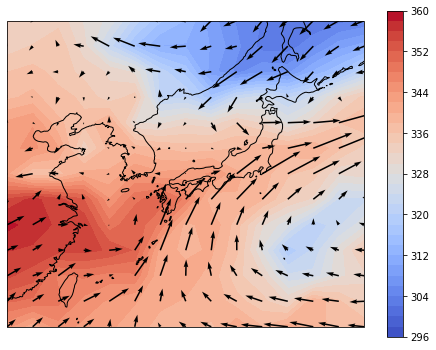

In [109]:
fig = plt.figure(figsize=[8,6])
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
p = ax.contourf(lon, lat, thetae, transform=ccrs.PlateCarree(),
               cmap="coolwarm", levels=np.arange(296, 362, 2))
ax.quiver(lon, lat, ds.uwnd, ds.vwnd)
ax.coastlines()
fig.colorbar(p)
plt.show()

大陸から高相当温位の空気が東シナ海を渡って日本列島に伸びつつある様子が分かります。

## Qベクトル

中高緯度では，気圧傾度力とコリオリ力がおよそ釣り合っています。

$$
u_\mathrm{g} = -\frac{1}{f_0}\frac{\partial\phi}{\partial y},\; v_\mathrm{g} = \frac{1}{f_0}\frac{\partial\phi}{\partial x}
$$ (ugvg)

これを地衡風平衡といいます。$f_0$は注目している緯度におけるコリオリパラメータです。
風は地衡風成分と非地衡風成分の和として表すことができます。

$$
u = u_\mathrm{g} + u_\mathrm{a},\;
v = v_\mathrm{g} + v_\mathrm{a}
$$

中高緯度でよく成り立つ準地衡風近似では，水平風はおよそ地衡風で近似されますが，
水平発散を考慮し非地衡風成分により鉛直流$\omega$が生じます。

$$
\frac{\partial u_\mathrm{a}}{\partial x} +
\frac{\partial v_\mathrm{a}}{\partial y} +
\frac{\partial \omega}{\partial p}
$$

{eq}`ugvg`を気圧$p$で微分すると温度風の関係

$$
f_0\frac{\partial u_\mathrm{g}}{\partial p} = \frac{R_\mathrm{d}}{p}\frac{\partial T}{\partial y},\;
f_0\frac{\partial v_\mathrm{g}}{\partial p} = -\frac{R_\mathrm{d}}{p}\frac{\partial T}{\partial x},\;
$$ (thermalwind)

が得られます。

準地衡風近似の下で熱力学の式は

$$
\frac{\mathrm{d_g}T}{\mathrm{d}t} - \left(\frac{p}{R_\mathrm{d}}\right)S_0\omega = 0
$$ (thermodyn_qg)

と表されます。

ここでラグランジュ微分は
$$
\frac{\mathrm{d_g}}{\mathrm{d}t} = \frac{\partial}{\partial t} + u_\mathrm{g}\frac{\partial}{\partial x} + v_\mathrm{g}\frac{\partial}{\partial y}
$$ (ddt_qg)

地衡風による移流で表されます。
$S_0=-\alpha_0\mathrm{d}\ln\theta_0/\mathrm{d}p$は安定度を表します。
$\alpha_0=\alpha_0(p),\,\theta_0=\theta_0(p)$は，それぞれ基本場の水平一様な比容と温位を表します。

温度風{eq}`thermalwind`の両辺のラグランジュ微分{eq}`thermalwind`を取り，{eq}`thermodyn_qg`を用いて整理すると鉛直流$\omega$の診断式

$$
S_0\nabla_\mathrm{h}^2\omega + f_0\frac{\partial^2\omega}{\partial p^2} = -2\nabla_\mathrm{h}^2\cdot\mathbf{Q}
$$ (qvector)

が得られます。{cite}`Hoskins:1978`

ここで$\nabla_\mathrm{h}^2$は水平ラプラシアンです。
ここで

$$
\mathbf{Q} \equiv -\frac{R_\mathrm{d}}{p}\left(\frac{\partial \mathbf{v}_g}{\partial x}\cdot\nabla_\mathrm{h}T,\;
\frac{\partial \mathbf{v}_g}{\partial y}\cdot\nabla_\mathrm{h}T\right)
$$

をQベクトルといいます。
Qベクトルの収束は上昇流，発散は下降流を表します。

MetPyを使ってQベクトルを計算しましょう。
Qベクトルでは準地衡風近似が仮定されているので，`mpcalc.geostrophic_wind()`を使ってジオポテンシャル高度から計算した地衡風を用います。
次に地衡風と気温から`mpcalc.q_vector()`を使って，Qベクトルを算出します。
Qベクトルからその発散を`mplcalc.divergence()`を使って計算しています。

In [97]:
ug, vg = mpcalc.geostrophic_wind(ds.hgt)
qx, qy = mpcalc.q_vector(ug, vg, ds.air, lev*units.hPa)
dq = mpcalc.divergence(qx, qy)

Qベクトルの発散を陰影で，気温を等値線で，Qベクトルを矢印で描画します。

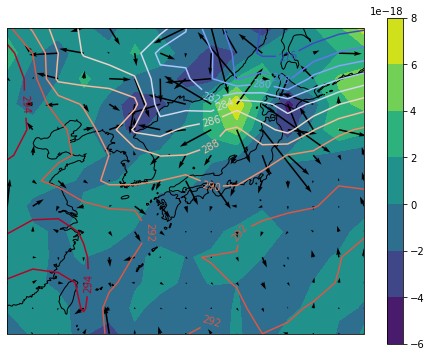

In [113]:
fig = plt.figure(figsize=[8,6])
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
p = ax.contourf(lon, lat, dq, transform=ccrs.PlateCarree())
c = ax.contour(lon, lat, ds.air, levels=np.arange(276, 296, 2), cmap="coolwarm")
ax.clabel(c, inline=True)
ax.quiver(lon, lat, qx, qy)
ax.coastlines()
fig.colorbar(p)
plt.show()

Qベクトルは北風の中心から発散しています。
日本海にある発散は西日本豪雨に先行して接近した台風第7号の北風に対応しています。

南向きのQベクトルは東西に伸びる等温線を横切って，鉛直流を誘導することにより梅雨前線を強化しています。